# Action Priors in 1D

## Imports

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
import tensorflow_probability as tfp
tfd = tfp.distributions
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

In [48]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
# load env
from src.envs.LinearEnv import LinearEnv
# load agent
from src.agents.AgentMLPTF import AgentMLPTF

# cell magic for reloading imported modules
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Environment
- State: 
    - $s \in \mathbb{R}^{(1)}$
- Simulates a frog jumping over pools of lava in 1D.
- Should use 1D arrays for states and actions, etc.

In [152]:
%autoreload 2
# instantiate env
env = LinearEnv(8,randomize=False, visualize=True)

In [153]:
# random agent
def random_agent(obs):
    return {"Action":np.random.uniform(-0.3,0.3,size=(1,))}

1


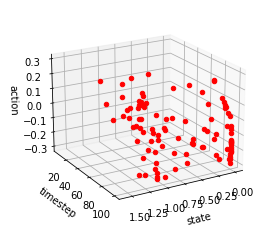

In [154]:
s = env.reset()
print(np.array(s.ndim))
eps = 100
states = []
for i in range(eps):
    a = random_agent(s)["Action"]
    s,r,done,_ = env.step(a)
    states.append(np.array([s,a]))
    # env.render(a,azimuth=60, elevation=20)

In [155]:
arr = np.array(states)
arr.shape

(100, 2, 1)

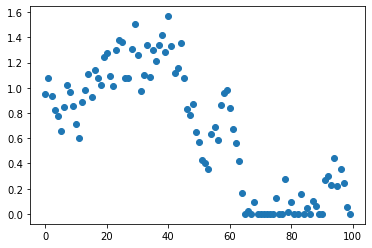

In [156]:
plt.scatter(list(range(arr.shape[0])),arr[:,0])

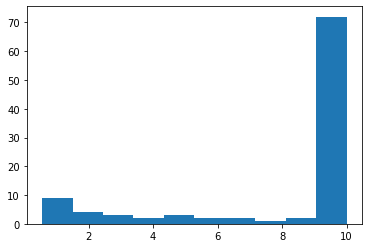

In [136]:
plt.hist(arr[:,0])
plt.show()

In [161]:
# get a single rollout for an agent in the environment and return the associated perfomance curve with std dev 
def get_episode_trajectory(env, agent, max_steps=1000):
    observation_list = []
    reward_list = []
    action_list = []
    value_list = []

    done = False
    obs = env.reset()
    for i in range(max_steps):
        observation_list.append(obs.copy())
        out = agent(obs)
        assert ("Action" in out), "The key 'Action' was missing from the agents output."
        action = out["Action"]
        obs, rew, done, _, = env.step(action)
        reward_list.append(rew)
        action_list.append(action.copy())
        if "Value" in out:
            value_list.append(out["Value"])
            
        if done:
            break
        
    ret = {
        "Observations": observation_list, 
        "Actions": action_list, 
        "Rewards": np.array(reward_list, dtype=np.float32)
    }
    if len(value_list) > 0:
        ret["Values"] = value_list
        
    return ret

In [162]:
traj = get_episode_trajectory(env, agent, max_steps=10);

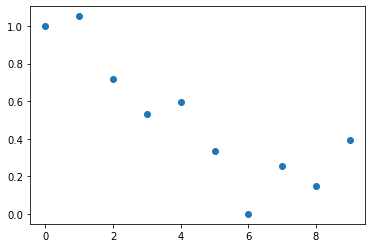

In [171]:
states = np.array(traj["Observations"])
plt.scatter(list(range(states.shape[0])),states[:,0])

In [164]:
def reward_to_go(rewards):
    return np.flip(np.cumsum(np.flip(rewards)))

In [165]:
def loss_pg(actions, log_probs, returns):
    log_probs = tf.reduce_sum(actions * log_probs, axis=1)
    return -tf.reduce_mean(returns * log_probs)

def loss_pg2(actions, log_probs, returns):
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)
    return tf.reduce_mean(returns * loss(actions, log_probs))

In [172]:
def train_policy_grad(env, agent, num_epochs=300):
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    log_reward = 0
    log_reward_list = []
    logging_period = 20
    
    for epoch in range(num_epochs):
        # get the training data
        traj = get_episode_trajectory(env, agent)
        pprint(traj)
        obs = np.stack(traj["Observations"])
        rew = traj["Rewards"]
        actions = traj["Actions"]
        
        # compute 'reward-to-go'
        rew_2_go = reward_to_go(rew)
        
        # compute gradients + update weights
        with tf.GradientTape() as tape:
            log_probs = agent(obs)["LogProbability"]
            loss = loss_pg(actions, log_probs, rew_2_go)
            
        gradients = tape.gradient(loss, agent.trainable_variables)
        optimizer.apply_gradients(zip(gradients, agent.trainable_variables))
        
        # log the reward
        log_reward += np.sum(rew)
        if (epoch % logging_period) == 0 and epoch != 0:
            template = 'Training Epoch {}, Averaged Return: {}'
            print(template.format(epoch, log_reward / logging_period))
            log_reward_list.append(log_reward / logging_period)
            log_reward = 0
       
    return (range(0, num_epochs, logging_period), log_reward_list)

In [173]:
agent_mlp_tf = AgentMLPTF()
(episodes, rewards) = train_policy_grad(env, agent)

{'Actions': [array([-0.06995554], dtype=float32),
             array([-0.8052721], dtype=float32),
             array([-0.8688596], dtype=float32),
             array([0.10588882], dtype=float32),
             array([-0.6171102], dtype=float32),
             array([-0.23064807], dtype=float32),
             array([-0.11791783], dtype=float32),
             array([-0.54497343], dtype=float32),
             array([-0.17912248], dtype=float32),
             array([0.2700941], dtype=float32),
             array([0.43241435], dtype=float32),
             array([-0.45803353], dtype=float32),
             array([0.17352235], dtype=float32),
             array([0.3127644], dtype=float32),
             array([0.24345091], dtype=float32),
             array([-0.47940558], dtype=float32),
             array([-0.49357867], dtype=float32),
             array([0.17218143], dtype=float32),
             array([-0.62430584], dtype=float32),
             array([0.03058884], dtype=float32),
             

AssertionError: 

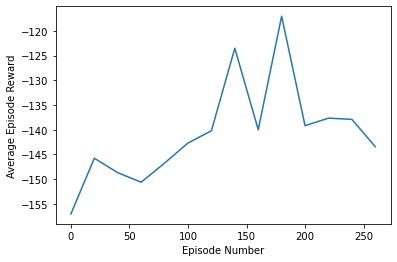

In [170]:
plt.plot(episodes[:-1], rewards)
plt.xlabel('Episode Number')
plt.ylabel('Average Episode Reward')
plt.show()